In [34]:
import pandas as pd
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
import re

### TEST:

**Load SPRAS ensemble pathway output**

- currently contains:
    - false positives (in ensemble, not in pathwaycommons individual graph)
    - true positives (in ensemble, also in pathway commons individual graph)
- compare it do 

In [ ]:
ensemble_sample = pd.read_csv('processed-data/ensemble-pathway-sample.txt', sep='\t')
ensemble_sample.drop(columns=['Direction'], inplace=True)
ensemble_sample['y_true'] = 0
ensemble_sample.head()

,Node1,Node2,Frequency,y_true
0,DCE2_HUMAN,GLSK_HUMAN,0.04,0
1,SSDH_HUMAN,chebi:16265,0.04,0
2,chebi:16265,SSDH_HUMAN,0.04,0
3,TACC1_HUMAN,RUXG_HUMAN,0.04,0
4,TACC1_HUMAN,KAT2A_HUMAN,0.04,0


**Add edges not in ensemble, but in pathway commons graph**

- i.e. add the false negatives

In [20]:
pathwaycommons_ind = pd.read_csv('pathway-commons-individual/Alanine,_aspartate_a.txt', sep='\t', header=None)

mapped_ids_reviewed = pd.read_csv('processed-data/mapped_ids_reviewed.csv', sep='\t')
mapped_ids_reviewed.head()

mapping_dict = dict(zip(mapped_ids_reviewed["gene_name"], mapped_ids_reviewed["entry_name"]))

pathwaycommons_ind[0] = pathwaycommons_ind[0].replace(mapping_dict)
pathwaycommons_ind[2] = pathwaycommons_ind[2].replace(mapping_dict)
pathwaycommons_ind.drop(columns=[1], inplace=True)
pathwaycommons_ind.rename(columns={0:'Node1', 2:'Node2'}, inplace=True)
pathwaycommons_ind

,Node1,Node2
0,AGT1_HUMAN,chebi:15428
1,AGT1_HUMAN,chebi:16891
2,AGT1_HUMAN,chebi:16977
3,AGT1_HUMAN,chebi:32816
4,AL4A1_HUMAN,CHEBI:371
...,...,...
258,chebi:30915,DHE4_HUMAN
259,chebi:30915,chebi:16015
260,chebi:32816,AGT1_HUMAN
261,chebi:32816,chebi:16891


In [ ]:
ytrue_pairs = set(zip(pathwaycommons_ind['Node1'], pathwaycommons_ind['Node2']))
ensemble_sample.loc[ensemble_sample[['Node1', 'Node2']].apply(tuple, axis=1).isin(ytrue_pairs), 'y_true'] = 1

# --- find pairs that are *only* in  and append them ------------------
missing_pairs = ytrue_pairs.difference(zip(ensemble_sample['Node1'], ensemble_sample['Node2']))
if missing_pairs:                      # only build a frame if something is missing
    new_rows = pd.DataFrame(list(missing_pairs), columns=['Node1', 'Node2'])
    new_rows['Frequency'] = 0          # per your rule
    new_rows['y_true']   = 1
    ensemble_sample = pd.concat([ensemble_sample, new_rows], ignore_index=True)

In [24]:
ensemble_sample

,Node1,Node2,Frequency,y_true
0,DCE2_HUMAN,GLSK_HUMAN,0.04,1
1,SSDH_HUMAN,chebi:16265,0.04,1
2,chebi:16265,SSDH_HUMAN,0.04,1
3,TACC1_HUMAN,RUXG_HUMAN,0.04,0
4,TACC1_HUMAN,KAT2A_HUMAN,0.04,0
...,...,...,...,...
259,DCE2_HUMAN,GNPI2_HUMAN,0.00,1
260,chebi:15428,chebi:32816,0.00,1
261,GLSK_HUMAN,chebi:16015,0.00,1
262,chebi:16467,chebi:15682,0.00,1


In [25]:
y_true = ensemble_sample["y_true"]
y_scores = ensemble_sample["Frequency"]

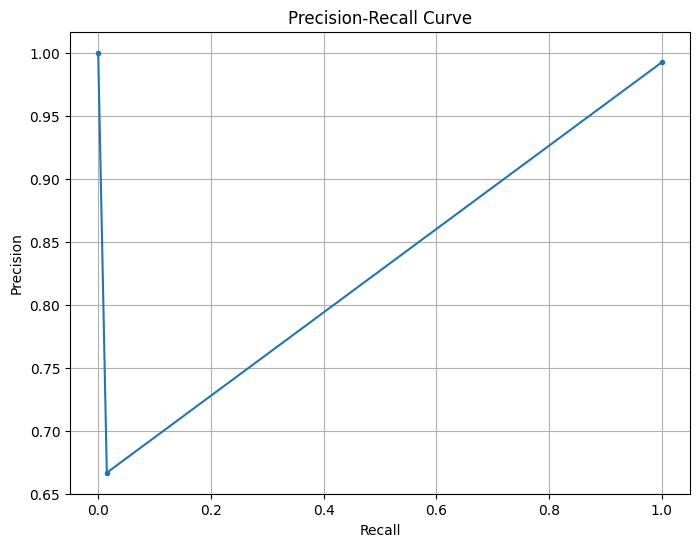

In [33]:
# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

### ACTUAL IMPLEMENTATION:

- loop through all spras ensemble pathway
    - match the ensemble pathway to the processed pc individual pathway
    - make the prc table:
        - remove direction from ensemble pathway
        - add y_true column and set all rows 0
        - if ensemble pathway has rows from processed pc individual pathway, set those y_true to 1
        - if there are rows in processed pc individual pathway that are not in ensemble pathway, add to prc df with y_true 1 and frequency 0
    - use prc table to make the pr curve image

In [ ]:
folder_path_1 = 'processed-data/spras-ml-ensembles'
spras_ensemble_pathways_list = [f for f in os.listdir(folder_path_1) if f.endswith('.txt')]

In [ ]:
folder_path_2 = 'processed-data/processed-pc-individual-pathways'
pc_processed_list = [f for f in os.listdir(folder_path_2) if f.endswith('.txt')]
list_labels = []
for filename in pc_processed_list:
    base = filename[:10]
    label = re.sub(r'\W+', '_', base).strip('_')
    if label not in list_labels:
        list_labels.append(label)
    else:
        print(label)

drug_metab
fatty_acid
fatty_acid
glycosamin
glycosamin
glycosphin
glycosphin
phenylalan
valine__le
73
73


In [ ]:
for pathway in spras_ensemble_pathways_list:

    # read ensemble pathway as df
    file_path = os.path.join(folder_path_1, pathway)
    ensemble_pathway_df = pd.read_csv(file_path, sep='\t')

    # match ensemble pathway to processed pathway commons file
    
